## Реализция RRT

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import time
from rtree import index
import random
from shapely.geometry import LineString, Polygon
import matplotlib.patches as patches
from matplotlib.colors import to_rgba


### Utilities

In [26]:
class Node:
    def __init__(self, x, y, cost=0, parent=None, child=None):
        self.x = x
        self.y = y
        self.parent = parent
        self.child = child
        self.cost = cost

In [27]:
class RectangleObstacle:
    def __init__(self, centers, side_sizes):
        self.centers = centers
        self.side_sizes = side_sizes
        self.bbox = self.get_bbox()
        self.shapely_polygon = self.get_shapely_polygon()

    def get_shapely_polygon(self):
        xmin = self.centers[0] - self.side_sizes[0]
        ymin = self.centers[1] - self.side_sizes[1]
        xmax = self.centers[0] + self.side_sizes[0]
        ymax = self.centers[1] + self.side_sizes[1]
        
        points = [
            (xmin, ymin),
            (xmax, ymin),
            (xmax, ymax),
            (xmin, ymax)
        ]
        return Polygon(points)

    
    def get_bbox(self):
        num_of_dimensions = len(self.centers)
        min_corner = np.empty(num_of_dimensions, float)
        max_corner = np.empty(num_of_dimensions, float)
        for j in range(num_of_dimensions):
            min_corner[j] = self.centers[j] - self.side_sizes[j]
            max_corner[j] = self.centers[j] + self.side_sizes[j]
        bbox = np.append(min_corner, max_corner)
        return tuple(bbox)
        
        

In [28]:
class PolygonObstacle:
    def __init__(self, points):
        self.points = points
        self.shapely_polygon = Polygon(points)
        self.bbox = self.get_bbox()

    def get_bbox(self):
        num_of_dimensions = len(self.points[0])
        min_corner = np.empty(num_of_dimensions, float)
        max_corner = np.empty(num_of_dimensions, float)
        for j in range(num_of_dimensions):
            min_corner[j] = min([i[j] for i in self.points])
            max_corner[j] = max([i[j] for i in self.points])
        bbox = np.append(min_corner, max_corner)
        return tuple(bbox)


In [29]:
class CircleObstacle:
    def __init__(self, centers, radius):
        self.centers = centers
        self.radius = radius
        self.bbox = self.get_bbox()

    def get_bbox(self):
        num_of_dimensions = len(self.centers)
        min_corner = np.empty(num_of_dimensions, float)
        max_corner = np.empty(num_of_dimensions, float)
        for j in range(num_of_dimensions):
            min_corner[j] = self.centers[j] - self.radius
            max_corner[j] = self.centers[j] + self.radius
        bbox = np.append(min_corner, max_corner)
        return tuple(bbox)

In [30]:
class WorkSpace:
    def __init__(self, dimensions, num_obstacles, min_obstacle_size=0.05, max_obstacle_size=0.1):
        self.dimensions = dimensions 
        self.num_obstacles: int = num_obstacles
        self.min_obstacle_size = min_obstacle_size 
        self.max_obstacle_size = max_obstacle_size 

        p = index.Property()
        p.dimension = 2
        self.obstacles = index.Index(interleaved=True, properties=p)
        self.obstacles_list = []
        self.create_obstacle_map()

        
    def create_obstacle_map(self):
        num_of_dimensions = len(self.dimensions)
        i = 0
        while i < self.num_obstacles:
            center = np.empty(num_of_dimensions, float)
            

            obstacle_type = np.random.uniform(0, 1)

            if  obstacle_type <= 0.4:
                sides_size = []
                for j, dimension in enumerate(self.dimensions):
                    min_side_length = dimension * self.min_obstacle_size
                    max_side_length = dimension * self.max_obstacle_size
                    side_size = random.uniform(min_side_length, max_side_length)
                    center[j] = random.uniform(side_size,
                                        dimension - side_size)
                    
                    sides_size.append(side_size)
                obstacle = RectangleObstacle(center, sides_size)

            elif 0.4 < obstacle_type <= 0.6:
                radius = random.uniform(min(self.dimensions) * self.min_obstacle_size, max(self.dimensions) * self.max_obstacle_size)
                for j, dimension in enumerate(self.dimensions):
                    center[j] = random.uniform(radius,
                                        dimension - radius)
                obstacle = CircleObstacle(center, radius)

            else:
                number_of_sides = random.randint(3, 7)
                points = [[0 for _ in range(num_of_dimensions)] for __ in range(number_of_sides)]
                for j, dimension in enumerate(self.dimensions):
                    min_side_length = dimension * 0.2
                    max_side_length = dimension * 0.2
                    center[j] = random.uniform(max_side_length,
                                        dimension - max_side_length)
                    for k in range(number_of_sides):
                        coord = np.random.uniform(center[j] - max_side_length, center[j] + max_side_length)
                        points[k][j] = coord
                    
                obstacle = PolygonObstacle(points)
                

            self.obstacles_list.append(obstacle)
            self.obstacles.insert(i, obstacle.bbox, obstacle)

            i += 1

### Vanilla RRT

In [31]:
class RRT:
    def __init__(self, workspace: WorkSpace, start: tuple, goal: tuple, max_iter: int = 1500, step_size: float = 0.03, goal_radius: float = 0.5, goal_bias=0.2, collision_check_points=10, stop_if_reached=True, visualisatoin=True):
        self.workspace: WorkSpace = workspace
        self.start: Node = start
        self.goal: Node = goal
        self.tree: list[Node] = [self.start]
        self.max_iter: int = max_iter
        self.completed_iterations = 0
        self.step_size: float = min(workspace.dimensions) * step_size
        self.goal_radius = self.step_size * goal_radius
        self.goal_bias = goal_bias
        self.collision_check_points = collision_check_points 
        self.stop_if_reached = stop_if_reached
        self.goal_node = Node(None, None, 0)
        self.visualisatoin = visualisatoin

        p = index.Property()
        p.dimension = len(workspace.dimensions)
        self.vertex_rtree = index.Index(interleaved=True, properties=p)
        self.vertex_count = 0
        self.head = self.add_vertex(start, None)
        

        # Параметры для графика
        if self.visualisatoin:
            self.fig, self.ax = plt.subplots()
            self.frames = []

    def dist(self, point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def add_vertex(self, coords: tuple, parent: Node, cost=0):
        current = Node(coords[0], coords[1], parent=parent, cost=cost)
        if parent:
            parent.child = current
        self.vertex_count += 1
        self.vertex_rtree.insert(self.vertex_count, coords + coords, current)
        return current

    def get_nearest_node(self, point: tuple[float, float]) -> Node:
        nearest = list(self.vertex_rtree.nearest(point, 1, objects=True))[0]
        return nearest.object
        
    def get_k_nearest_nodes(self, point, k) -> list[Node]:
        k_nearest = list(self.vertex_rtree.nearest(point, k, objects=True))
        return k_nearest

    def get_random_point(self):
        goal_bias_condition = np.random.uniform(0, 1)
        if goal_bias_condition < self.goal_bias:
            x = self.goal
        else:
            x = tuple(random.uniform(0, dimension) for dimension in self.workspace.dimensions)
        return x
    
    def is_collision_free(self, start, end):
        start, end = np.array(start), np.array(end)
        line = LineString([start, end])
        v = end - start
        u = v / (np.sqrt(np.sum(v ** 2))) # единичный вектор
        eps = self.step_size / (self.collision_check_points + 1) # промежутков на 1 больше точек
        next_point = start
        for _ in range(self.collision_check_points + 1):
            next_point += u * eps
            point_bbox_format = np.hstack((next_point, next_point))
            if self.workspace.obstacles.count(point_bbox_format) == 0:
                continue
            else:
                possible_intersections = self.workspace.obstacles.intersection(point_bbox_format, objects=True)
                for item in possible_intersections:
                    if type(item.object) == CircleObstacle:
                        if np.linalg.norm(item.object.centers - next_point) <= item.object.radius:
                            return False
                    elif isinstance(item.object, (RectangleObstacle, PolygonObstacle)):
                        if line.intersects(item.object.shapely_polygon):
                            return False
                    # else:
                    #     return False
        return True


    def steer(self, start: tuple, end: tuple) -> tuple:
        start, end = np.array(start), np.array(end)
        v = end - start
        u = v / (np.sqrt(np.sum(v ** 2))) # единичный вектор
        steered_point = start + u * self.step_size

        if self.is_collision_free(start, steered_point):
            return True, tuple(steered_point)
        return False, None
    

    def run_rrt(self):

        if self.visualisatoin:
            all_lines = []
            self.setup_visualization()
            self.frames.append([])

        for _ in range(self.max_iter):
            
            random_point = self.get_random_point()
            nearest_node = self.get_nearest_node(random_point)
            status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            # in case of collision
            while not status:
                random_point = self.get_random_point()
                nearest_node = self.get_nearest_node(random_point)
                status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            
            new_node = self.add_vertex(new_node, nearest_node, cost=nearest_node.cost + self.dist(new_node, (nearest_node.x, nearest_node.y)))
            self.completed_iterations += 1
            
            if new_node.parent and self.visualisatoin:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                                [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            
            if np.linalg.norm([new_node.x - self.goal[0], new_node.y - self.goal[1]]) < self.goal_radius:
                if new_node.cost < self.goal_node.cost or self.goal_node.cost == 0:
                    self.goal_node = new_node
                if self.stop_if_reached:
                    break

        return self.goal_node

    def setup_visualization(self):
        self.ax.set_xlim(0, self.workspace.dimensions[0])
        self.ax.set_ylim(0, self.workspace.dimensions[1])
        self.ax.grid(True)

        colors = {
            RectangleObstacle: {
                "face": "lightsteelblue",
                "edge": "steelblue",
                "alpha": 0.6
            },
            CircleObstacle: {
                "face": "lightcoral",
                "edge": "indianred",
                "alpha": 0.6
            },
            PolygonObstacle: {
                "face": "lightgreen",
                "edge": "seagreen",
                "alpha": 0.6
            }
        }

        for obstacle in self.workspace.obstacles_list:
            opts = colors.get(type(obstacle), {"face": "lightgray", "edge": "gray", "alpha": 0.6})

            if isinstance(obstacle, RectangleObstacle):
                xmin, ymin, xmax, ymax = obstacle.bbox
                width, height = xmax - xmin, ymax - ymin
                patch = patches.Rectangle(
                    (xmin, ymin), width, height,
                    facecolor=opts["face"],
                    edgecolor=opts["edge"],
                    linewidth=1.5,
                    alpha=opts["alpha"]
                )

            elif isinstance(obstacle, CircleObstacle):
                patch = patches.Circle(
                    obstacle.centers, obstacle.radius,
                    facecolor=opts["face"],
                    edgecolor=opts["edge"],
                    linewidth=1.5,
                    alpha=opts["alpha"]
                )

            else:  
                patch = patches.Polygon(
                    obstacle.points, closed=True,
                    facecolor=opts["face"],
                    edgecolor=opts["edge"],
                    linewidth=1.5,
                    alpha=opts["alpha"]
                )

            self.ax.add_patch(patch)

        self.ax.plot(
            self.start[0], self.start[1],
            marker='o', markersize=10,
            color='darkblue', label='Start'
        )
        self.ax.plot(
            self.goal[0], self.goal[1],
            marker='*', markersize=12,
            color='crimson', label='Goal'
        )

        self.ax.legend(loc='upper right')
        
        

 


In [32]:
def make_animation(frames, fig, outputfile_name):
    """
    Создание анимации
    """
    if not frames:
        raise Exception("Нет кадров для анимации")
    
    tree_animation = animation.ArtistAnimation(fig, frames, interval=50)
    
    tree_animation.save(outputfile_name, writer='pillow', fps=15)
    plt.show()    


Запустим наш Vanilla RRT с флагом `goal_bias` (с вероятностью 0.2 в качестве рандомной точки берем итоговую точку)

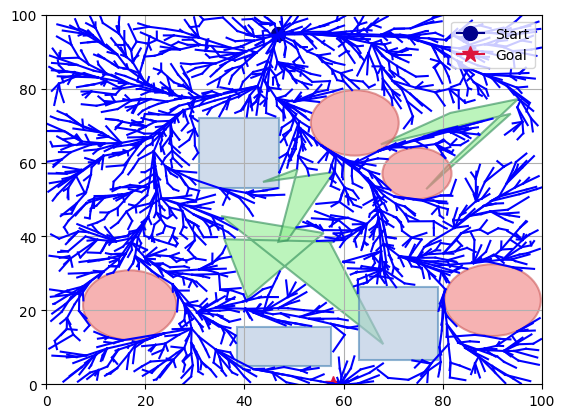

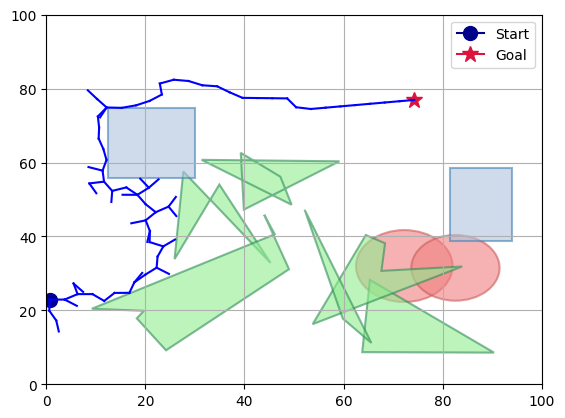

Animation completed and saved as rrt_goal_bias.gif.


In [33]:
num_obstacles = 10  
map_size = [100, 100]

map = WorkSpace(map_size, num_obstacles)

start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))

rrt = RRT(map, start, goal)

# Анимация
rrt.run_rrt()
make_animation(rrt.frames, rrt.fig, 'rrt_goal_bias.gif')
print(f"Animation completed and saved as rrt_goal_bias.gif.")

### RRT*

In [34]:
class RRTStar(RRT):
    def __init__ (self, workspace: WorkSpace, start: tuple, goal: tuple, max_iter: int = 1000, step_size: float = 0.03, goal_radius: float = 0.5, goal_bias=0.2, collision_check_points=10, rewire_cnt=1, stop_if_reached=True, visualisation=True):
        super().__init__(workspace, start, goal, max_iter, step_size, goal_radius, goal_bias, collision_check_points, stop_if_reached, visualisation)
        self.rewire_cnt = rewire_cnt

    def dist(self, point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def cnt_path_cost(self, node1: Node, node2: Node):
        cost = 0
        while node2 != node1:
            if node2.parent is None:
                break
            current_node = node2.parent
            cost += self.dist((node2.x, node2.y), (current_node.x, current_node.y))
            node2 = current_node
        return cost
    
    def get_nearby_nodes_with_cost(self, point):
        nearby_nodes = self.get_k_nearest_nodes(point, min(self.rewire_cnt, self.vertex_count))
        nearby_nodes_cost = [(item.object.cost + self.dist((item.object.x, item.object.y), point), item.object) for
                  item in nearby_nodes]
        return nearby_nodes_cost
    
    def rewire(self, new_node, nearby_nodes_with_cost):
        for cost, node in nearby_nodes_with_cost:
            curr_cost = node.cost
            tent_cost = new_node.cost + self.dist((new_node.x, new_node.y), (node.x, node.y))
            if tent_cost < curr_cost and self.is_collision_free((node.x, node.y), (new_node.x, new_node.y)):
                node.parent = new_node
                node.cost = tent_cost
                
    def choose_parent(self, point, nearby_nodes_with_cost):
        min_cost = float('inf')
        best_parent = None
        
        for cost, node in nearby_nodes_with_cost:
            if cost < min_cost and ((node.x, node.y) != point) and self.is_collision_free((node.x, node.y), point):
                min_cost = cost
                best_parent = node
                
        return best_parent
    
    def run_rrt_star(self):

        if self.visualisatoin:
            all_lines = []
            self.setup_visualization()
            self.frames.append([])

        for _ in range(self.max_iter):
            
            
            random_point = self.get_random_point()
            nearest_node = self.get_nearest_node(random_point)
            status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            # in case of collision
            while not status:
                random_point = self.get_random_point()
                nearest_node = self.get_nearest_node(random_point)
                status, new_node = self.steer((nearest_node.x, nearest_node.y), random_point)

            nearest_nodes_with_cost = self.get_nearby_nodes_with_cost(new_node)
            best_parent = self.choose_parent(new_node, nearest_nodes_with_cost)
            if best_parent is None:
                continue
            cost = best_parent.cost + self.dist((best_parent.x, best_parent.y), new_node)
            new_node = self.add_vertex(new_node, best_parent, cost=best_parent.cost + self.dist((best_parent.x, best_parent.y), new_node))
            new_node.cost = cost
    
            self.rewire(new_node, nearest_nodes_with_cost)
            self.completed_iterations += 1

            
            if new_node.parent and self.visualisatoin:
                line, = self.ax.plot([new_node.x, new_node.parent.x], 
                                [new_node.y, new_node.parent.y], "-b")
                all_lines.append(line)
                self.frames.append(all_lines.copy())
            
            # check if we reached the goal
            if np.linalg.norm([new_node.x - self.goal[0], new_node.y - self.goal[1]]) < self.goal_radius:
                if new_node.cost < self.goal_node.cost or self.goal_node.cost == 0:
                    self.goal_node = new_node
                if self.stop_if_reached:
                    break

        return self.goal_node
        




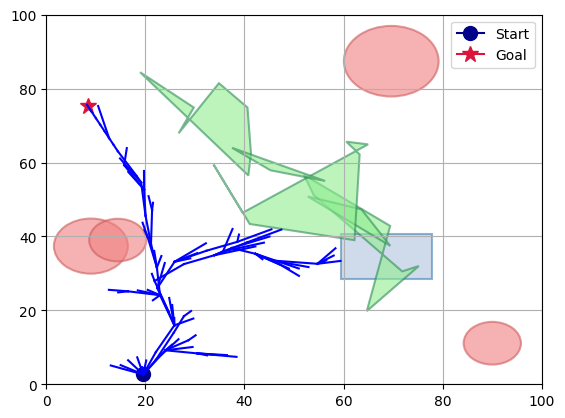

Animation completed and saved as rrt_star.gif.


In [35]:
num_obstacles = 10
map_size = [100, 100]

map = WorkSpace(map_size, num_obstacles)

start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))

rrt_star = RRTStar(map, start, goal, rewire_cnt=5, collision_check_points = 20, step_size=0.02)

# Анимация
rrt_star.run_rrt_star()
make_animation(rrt_star.frames, rrt_star.fig, 'rrt_star.gif')
print(f"Animation completed and saved as rrt_star.gif.")

### Сравнение RRT и RRT*

Ниже просто самое базовое сравнение двух алгоритмов. Далее будет более подробный анализ.

In [36]:
def calculate_path_length(node):
    length = 0
    current = node
    while current.parent:
        length += np.linalg.norm([current.x - current.parent.x, 
                                current.y - current.parent.y])
        current = current.parent
    return length

In [37]:
RANDOM_SEED = 53
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


map_size = [100, 100]
num_obstacles = 10
map = WorkSpace(map_size, num_obstacles)
start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
        
# RRT
rrt = RRT(map, start, goal, collision_check_points = 20, step_size=0.02)
start_time = time.time()
rrt_tail = rrt.run_rrt()
rrt_time = time.time() - start_time
print('rrt time', rrt_time)
print('rrt path length', rrt_tail.cost)

print('----------------------------------------------------------------------------------------------------------')

# RRT*
rrt_star = RRTStar(map, start, goal, rewire_cnt=3, collision_check_points=20, step_size=0.02)
start_time = time.time()
rrt_star_tail = rrt_star.run_rrt_star()
rrt_star_time = time.time() - start_time
print('rrt star time', rrt_star_time)
print('rrt star path length', rrt_star_tail.cost)





rrt time 0.019360065460205078
rrt path length 41.99999999999997
----------------------------------------------------------------------------------------------------------
rrt star time 0.05973362922668457
rrt star path length 39.99459189177382


### Results

#### RRT vs RRT* по 10 запусков на одной карте

In [38]:
import pandas as pd
from IPython.display import HTML, display

In [39]:
RANDOM_SEED = 93
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

plt.ioff() 
map_size = [100, 100]
num_obstacles = 10
map = WorkSpace(map_size, num_obstacles)
start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
while not (map.obstacles.count(np.hstack((start + start))) == 0) or not (map.obstacles.count(np.hstack((goal + goal))) == 0):
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(len(map_size)))


mean_tree_size_rrt = 0
mean_tree_size_rrt_gb = 0
mean_tree_size_rrtstar = 0
mean_tree_size_rrtstar_gb = 0

mean_time_rrt = 0
mean_time_rrtstar = 0
mean_time_rrt_gb = 0
mean_time_rrtstar_gb = 0

mean_path_length_rrt = 0
mean_path_length_rrtstar = 0
mean_path_length_rrt_gb = 0
mean_path_length_rrtstar_gb = 0

cnt_rrt = 10
cnt_rrtstar = 10
cnt_rrt_gb = 0
cnt_rrtstar_gb = 0

rrt_gb = RRT(map, start, goal, collision_check_points = 20, step_size=0.02, goal_bias=0.2)
rrt = RRT(map, start, goal, collision_check_points = 20, step_size=0.02, goal_bias=0)
rrtstar_gb = RRTStar(map, start, goal, rewire_cnt=5, collision_check_points = 20, step_size=0.02, goal_bias=0.2)
rrtstar = RRTStar(map, start, goal, rewire_cnt=5, collision_check_points = 20, step_size=0.02, goal_bias=0)

for _ in range(10):

    # RRT goal_bias
    rrt_gb = RRT(map, start, goal, collision_check_points = 20, step_size=0.02, goal_bias=0.2)
    start_time = time.time()
    rrt_gb_tail = rrt_gb.run_rrt()
    mean_time_rrt_gb += time.time() - start_time
    mean_tree_size_rrt_gb += rrt_gb.completed_iterations
    mean_path_length_rrt_gb += rrt_gb_tail.cost

    # RRT 
    rrt = RRT(map, start, goal, collision_check_points = 20, step_size=0.02, goal_bias=0, max_iter=3000)
    start_time = time.time()
    rrt_tail = rrt.run_rrt()
    finish_time = time.time()
    if rrt_tail.cost == 0:
        cnt_rrt -= 1
    else:
        mean_time_rrt += finish_time - start_time
        mean_tree_size_rrt += rrt.completed_iterations
        mean_path_length_rrt += rrt_tail.cost


    # RRT* goal_bias
    rrtstar_gb = RRTStar(map, start, goal, rewire_cnt=5, collision_check_points = 20, step_size=0.02, goal_bias=0.2)
    start_time = time.time()
    rrtstar_gb_tail = rrtstar_gb.run_rrt_star()
    mean_time_rrtstar_gb += time.time() - start_time
    mean_tree_size_rrtstar_gb += rrtstar_gb.completed_iterations
    mean_path_length_rrtstar_gb += rrtstar_gb_tail.cost

    # RRT* 
    rrtstar = RRTStar(map, start, goal, rewire_cnt=5, collision_check_points = 20, step_size=0.02, goal_bias=0, max_iter=3000)
    start_time = time.time()
    rrtstar_tail = rrtstar.run_rrt_star()
    finish_time = time.time()
    if rrtstar_tail.cost == 0:
        cnt_rrtstar -= 1
    else:
        mean_time_rrtstar += finish_time - start_time
        mean_tree_size_rrtstar += rrtstar.completed_iterations
        mean_path_length_rrtstar += rrtstar_tail.cost




results = [
    {
        "Algorithm": "RRT",
        "Tree Size":  mean_tree_size_rrt / cnt_rrt,
        "Time (s)":     mean_time_rrt / cnt_rrt,
        "Path Length":  mean_path_length_rrt / cnt_rrt
    },
    {
        "Algorithm": "RRT goal‐bias",
        "Tree Size":  mean_tree_size_rrt_gb / 10,
        "Time (s)":     mean_time_rrt_gb / 10,
        "Path Length":  mean_path_length_rrt_gb / 10
    },
    {
        "Algorithm": "RRT*",
        "Tree Size":  mean_tree_size_rrtstar / cnt_rrtstar,
        "Time (s)":     mean_time_rrtstar / cnt_rrtstar,
        "Path Length":  mean_path_length_rrtstar / cnt_rrtstar
    },
    {
        "Algorithm": "RRT* goal‐bias",
        "Tree Size":  mean_tree_size_rrtstar_gb / 10,
        "Time (s)":     mean_time_rrtstar_gb / 10,
        "Path Length":  mean_path_length_rrtstar_gb / 10
    }
]


# Создаём DataFrame с результатами
df = pd.DataFrame(results).set_index("Algorithm")

df



/var/folders/2p/w7_frqdd6fx2bfd7k744c_wc0000gn/T/ipykernel_16785/2644290455.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots()


,Tree Size,Time (s),Path Length
Algorithm,,,
RRT,2300.0,2.615819,152.000000
RRT goal‐bias,504.6,0.723861,150.000000
RRT*,2131.6,3.499231,135.420944
RRT* goal‐bias,502.5,0.874148,116.315173


In [41]:
RANDOM_SEED = 93
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
plt.ioff()


map_size = [100, 100]
num_obstacles= 10
ws = WorkSpace(map_size, num_obstacles)
start = tuple(np.random.uniform(0, map_size[i]) for i in range(2))
goal  = tuple(np.random.uniform(0, map_size[i]) for i in range(2))
while ws.obstacles.count(np.hstack((start+start)))>0 or ws.obstacles.count(np.hstack((goal+goal)))>0:
    start = tuple(np.random.uniform(0, map_size[i]) for i in range(2))
    goal = tuple(np.random.uniform(0, map_size[i]) for i in range(2))


max_iters = [100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 10000]

lens_rrt_gb = []
lens_rrtstar_gb = []



for mi in max_iters:
    mean_rrt = 0
    mean_rrtstar = 0
    for i in range(5):
        # RRT goal-bias
        rrt_gb = RRT(ws, start, goal,
                    collision_check_points=20,
                    step_size=0.02,
                    goal_bias=0.2,
                    max_iter=mi,
                    stop_if_reached=False,
                    visualisatoin=False)
        tail1 = rrt_gb.run_rrt()
        mean_rrt += tail1.cost
        # lens_rrt_gb.append(calculate_path_length(tail1))
        plt.close('all') 
        
        # RRT* goal-bias
        rrtstar_gb = RRTStar(ws, start, goal,
                            rewire_cnt=5,
                            collision_check_points=20,
                            step_size=0.02,
                            goal_bias=0.2,
                            max_iter=mi,
                            stop_if_reached=False,
                            visualisation=False)
        tail2 = rrtstar_gb.run_rrt_star()
        mean_rrtstar += tail2.cost
        # lens_rrtstar_gb.append(calculate_path_length(tail2))
        plt.close('all') 

    lens_rrt_gb.append(mean_rrt / 5)
    lens_rrtstar_gb.append(mean_rrtstar / 5)


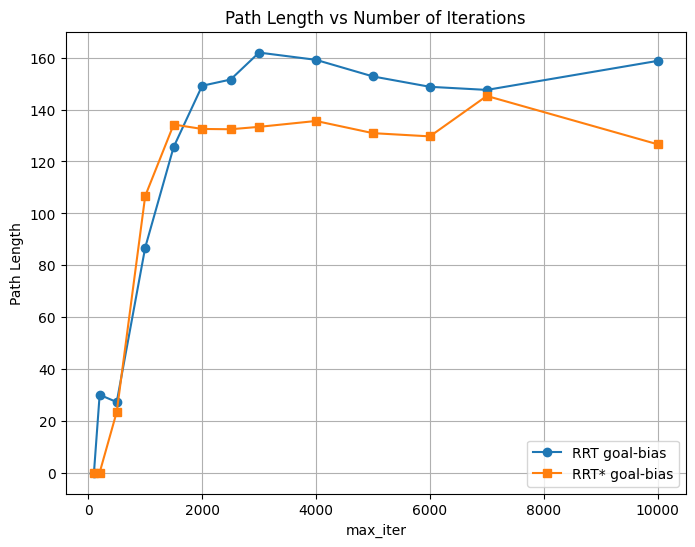

In [42]:
plt.ion()
plt.figure(figsize=(8,6))
plt.plot(max_iters, lens_rrt_gb, marker='o', label='RRT goal-bias')
plt.plot(max_iters, lens_rrtstar_gb, marker='s', label='RRT* goal-bias')
plt.xlabel('max_iter')
plt.ylabel('Path Length')
plt.title('Path Length vs Number of Iterations')
plt.grid(True)
plt.legend()
plt.show()